In [18]:
from statistics import linear_regression

import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.linear_model import LinearRegression as ls
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import seaborn as sns


from analysis import Analysis

In [19]:
#data explanation
analyzer = Analysis()
data = analyzer.loadData('data/raw_data/zal_hausing.csv')
print(data.head().to_string())
analyzer.findMissingValues(data)
data = data.drop(columns=['zainter'])
print(data.head().to_string())

   pietro  izby  powierzchnia  zadrzewienie   autostrada   przemysł     centrum     jezioro        lasy     tramwaj     policja      szkola     cena  zainter
0       0     4         65.10         13.44   3153.81100   63.63961  7366.52600  1384.37700   538.56290   472.70500  2996.06800  1324.84000  4531.49    False
1       3     2         32.70         21.56   8452.07227  134.35030  2818.24414  1601.85046  1471.20703    96.04687  1860.02686   289.87067  1972.32     True
2       0     3         40.98          1.20   6571.53900   89.44272  2269.05800  1264.80200   798.82730    40.31129   734.20030   261.72500  2037.58     True
3       3     2         49.53          0.48  11763.63574  207.00241  5615.26953  5416.94092   236.48466  2214.45825  2338.56787   182.48288  5471.43    False
4       4     3         81.40         21.72   4384.95500  169.18920  2375.39500  3475.80900  2024.84600   317.56890  1301.76800    65.00000  3482.80     True
No missing values.
   pietro  izby  powierzchnia  za

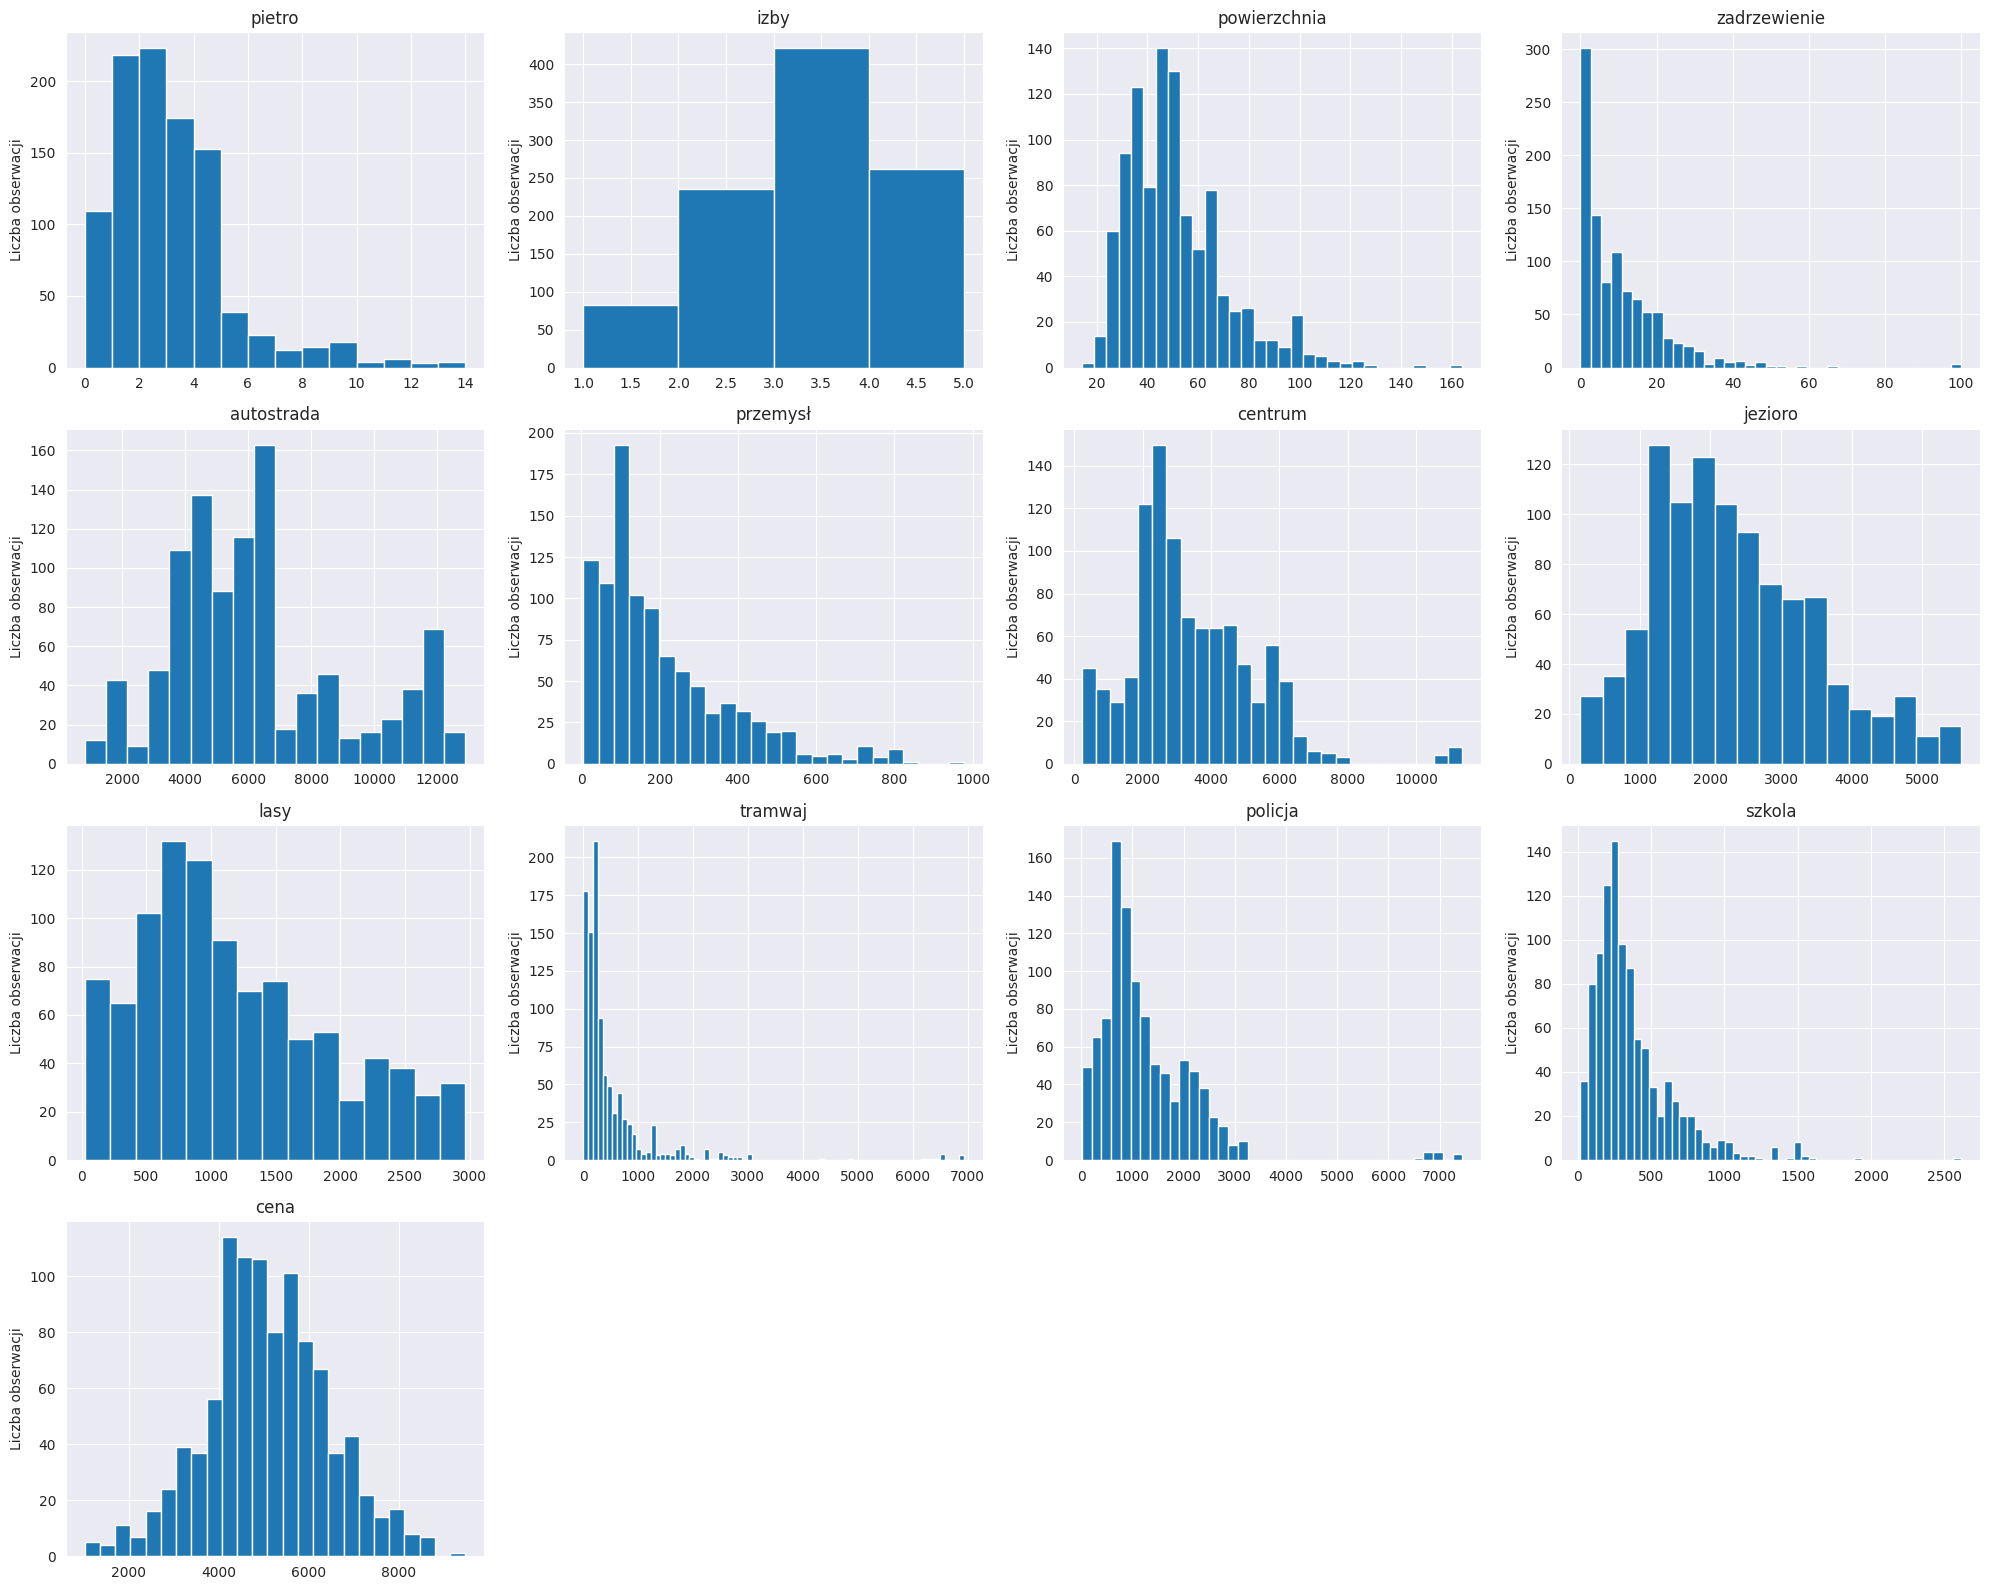

In [20]:

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    axes[i].hist(data[column].dropna(), bins='auto')
    axes[i].set_title(column)
    axes[i].set_ylabel("Liczba obserwacji")

for j in range(13, 16):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


MAPE: 22.99%


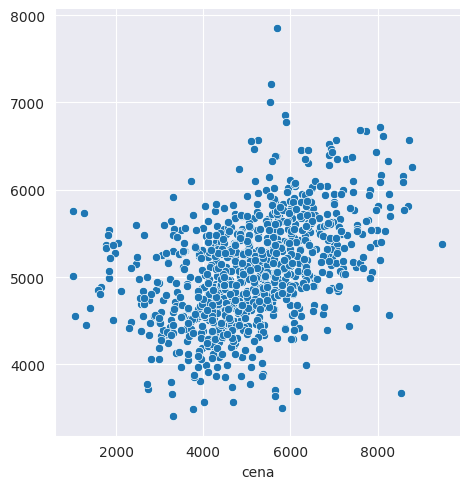

In [21]:

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Model OLS
model_o = ls().fit(X, y)

# Predykcja
yhat = model_o.predict(X)

# MAPE
mape_o = mean_absolute_percentage_error(y, yhat)
print(f"MAPE: {mape_o:.2%}")
sns.relplot(x=y,y=yhat)

Zmienne nie zostały przeskalowane. Model nie jest dobrze dopasowany. Jest nieznaczna korelacja  między $y$ a $\hat{y}$

MAPE: 201.68%


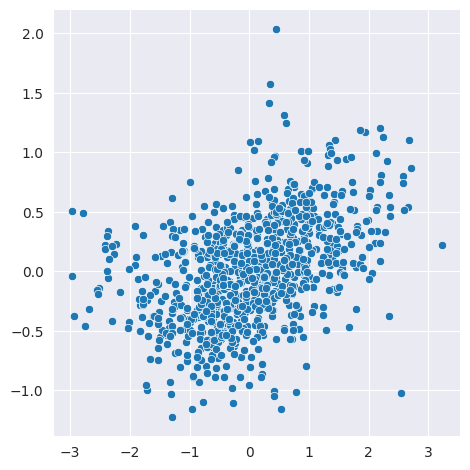

In [22]:

# skalowanie zmiennych
scaler = StandardScaler().fit(data)
scaled = scaler.transform(data)
X = scaled[:,:-1]
y = scaled[:,-1]
model_s = ls().fit(X,y)
yhat = model_s.predict(X)
mape_s = mean_absolute_percentage_error(y,yhat)
print(f"MAPE: {mape_s:.2%}")
sns.relplot(x=y,y=yhat)


Skalowanie niewiele pomogło, dalej nie ma znaczącej korelacji.

MAPE 256.04%


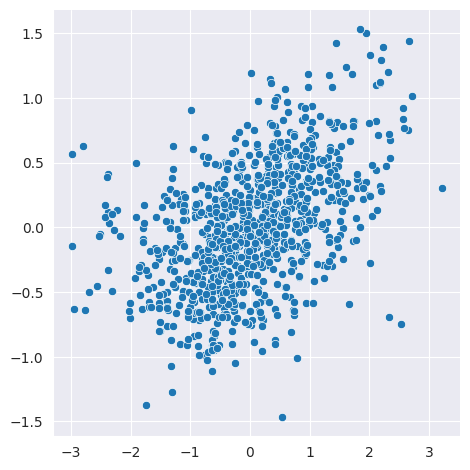

In [23]:
# transformacja potęgowa
transformer_p = PowerTransformer().fit(data)
transformed = transformer_p.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_p = ls().fit(X,y)
yhat = model_p.predict(X)
mape_p = mean_absolute_percentage_error(y,yhat)
print(f"MAPE {mape_p:.2%}")
sns.relplot(x=y,y=yhat)

MAE: 0.20607738522077101


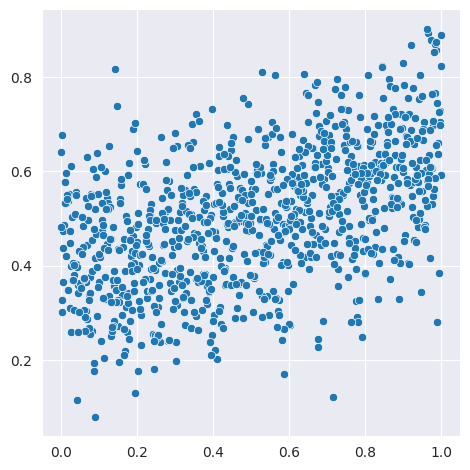

In [24]:
transformer_q = QuantileTransformer().fit(data)
transformed = transformer_q.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_q = ls().fit(X,y)
yhat = model_q.predict(X)
mae_q = mean_absolute_error(y,yhat)
print(f"MAE: {mae_q}")
sns.relplot(x=y,y=yhat)


In [25]:
coefs = pd.DataFrame((model_o.coef_,model_s.coef_,model_p.coef_,model_q.coef_),columns=data.columns[:-1])
coefs = coefs.T
coefs.columns=["Ord","scaled","GLS-YJ", "GLS-Q"]
coefs

,Ord,scaled,GLS-YJ,GLS-Q
pietro,-29.312115,-0.047814,-0.028141,-0.036650
izby,-187.251246,-0.136383,-0.096654,-0.103418
powierzchnia,-9.762576,-0.141210,-0.188208,-0.213436
zadrzewienie,-14.176849,-0.116925,-0.157391,-0.186083
autostrada,0.069186,0.141327,0.070172,0.083430
przemysł,1.039137,0.130839,0.186727,0.186273
centrum,-0.003658,-0.004837,-0.078649,0.093465
jezioro,-0.157398,-0.131396,-0.115366,-0.137458
lasy,0.072115,0.039111,0.020551,0.140957
tramwaj,0.019204,0.012231,0.145458,0.090324


Analizując wartości współczynników modelu z przeskalowanymi danymi, można zauważyć, że istotne wydają się cechy Izby, powierzchnia, zadrzewienie oraz jeziora, których wzrost wartości obniża wartość predykcji ceny, oraz autostrada i przemysł, które ją zwiększają.

Transformacja potęgowa podnosi istotność powierzchni, zadrzewienia oraz przemysłu. Co ważne, znacznie zwiększyła istotność Tramwaju, który był pomijalny w modelu bez transformacji. Równiez zmienna centrum po transformacjach okazuje się istotniejsza.

Są niewielkie różnice między tranformacją kwantylową i potęgową. Jedyną istotną zmianą jest zwiększenie istotności Lasów przez transformacje kwantylową. Lasy były pomijalne zarówno w modelu bez transformacji jak i w potęgowej.

*Czy wszystkie zmienne wyjaśniające powinny być numeryczne?*


W rozpatrywanym modelu regresji liniowej każda zmienna musi byc numeryczna. Jeśli zachodzi potrzeba uwzględnienia zmiennej kategorycznej, to najlepiej zastosować one-hot encoding. Niestety wiąże się to ze zwiększeniem liczby wymiarów. Rozwiązaniem pośrednim mogłoby być zamiana kategorii na liczby całkowite, wiąże się to jednak z wieloma problemami. Niekoniecznie wzrost wartości zmiennej zawsze by zwiększał wartość predykcji albo zawsze ją zmniejszał. Podejście do problemu zależy od danych.

*Zmienne o małej przydatności dla modelu liniowego*

Zmienne pomijalne w modelu przed transformacjami to Tramwaj(0.01), Lasy(0.02), Piętro(-0.047) oraz Centrum(-0.004). Po tranformacji potęgowej mało przydatne są tylko Lasy(0.02) i Piętro(-0.028). Po tranformacji kwantylowej jedynie Piętro(-0.036).

In [ ]:
from pygam import LinearGAM, s, f, l
from pygam import LogisticGAM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder